<a href="https://colab.research.google.com/github/Adricarpin/TensorFlow-notebooks/blob/master/Computer%20vision/Image_classification_malaria.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Download Data

For information about the dataset visit: https://www.tensorflow.org/datasets/catalog/malaria

In [ ]:
import tensorflow_datasets as tfds


We load training data as a  `tf.data.Dataset` and the information associated to the dataset as `tdfs.core.DatasetInfo`

In [ ]:
train_data, ds_info = tfds.load(name="malaria", 
                                             shuffle_files=True, # shuffle files on download?
                                             as_supervised=True, # download data in tuple format (sample, label), e.g. (image, label)
                                             with_info=True) # include dataset metadata? if so, tfds.load() returns tuple (data, ds_info)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/malaria/1.0.0.incompleteWNF5SZ/malaria-train.tfrecord


  0%|          | 0/27558 [00:00<?, ? examples/s]

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


# Become one with data

Let's see what this dataset is about. First we can have a look at the information:

In [ ]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})

In [ ]:
class_names = ds_info.features["label"].names
class_names

['parasitized', 'uninfected']

In [ ]:
# Direcotry where the images are stored
train_dir = '/root/tensorflow_datasets/downloads/extracted/ZIP.ceb.nlm.nih.gov_proj_malaria_cell_imagesCLJ1vGxXDKcJmHnYfoar_K3ipRQWtxIVA-imvIbvBbs.zip/cell_images/'


Walk through the folder, show number of directories and images in directories:

In [ ]:
import os
for dirpath, dirnames, filenames in os.walk(train_dir): 
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

There are 2 directories and 0 images in '/root/tensorflow_datasets/downloads/extracted/ZIP.ceb.nlm.nih.gov_proj_malaria_cell_imagesCLJ1vGxXDKcJmHnYfoar_K3ipRQWtxIVA-imvIbvBbs.zip/cell_images/'.
There are 0 directories and 13780 images in '/root/tensorflow_datasets/downloads/extracted/ZIP.ceb.nlm.nih.gov_proj_malaria_cell_imagesCLJ1vGxXDKcJmHnYfoar_K3ipRQWtxIVA-imvIbvBbs.zip/cell_images/Parasitized'.
There are 0 directories and 13780 images in '/root/tensorflow_datasets/downloads/extracted/ZIP.ceb.nlm.nih.gov_proj_malaria_cell_imagesCLJ1vGxXDKcJmHnYfoar_K3ipRQWtxIVA-imvIbvBbs.zip/cell_images/Uninfected'.


View a random image. We can run these cells a few times in order to see how the Dataset looks like.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random

def view_random_image(target_dir, target_class):
  target_folder = target_dir+target_class

  random_image = random.sample(os.listdir(target_folder), 1)

  img = mpimg.imread(target_folder + "/" + random_image[0])
  plt.imshow(img)
  plt.title(target_class)
  plt.axis("off");

  print(f"Image shape: {img.shape}") # show the shape of the image

  return img

Image shape: (127, 121, 3)


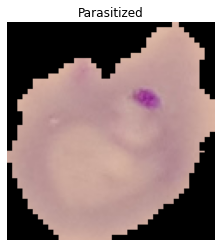

In [ ]:
# View a random image from the training dataset
img = view_random_image(target_dir=train_dir,
                        target_class="Parasitized")

#  From folders with images to tensoflow datasets

We will use `image_dataset_from_directory` in order to make datasets from images stored in folders. Data will be stored in pairs of images and labels. The labels will be the names of the folders where images are stored. We also split data into train and validation. 

In [ ]:
import tensorflow as tf

In [ ]:
train_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=(120, 120),
                                                                            label_mode="binary",
                                                                            batch_size=32,
                                                                 validation_split=0.2,
                                                                 subset='training',
                                                                 seed=17)

validation_data = tf.keras.preprocessing.image_dataset_from_directory(directory=train_dir,
                                                                            image_size=(120, 120),
                                                                            label_mode="binary", 
                                                                            batch_size=32,
                                                                 validation_split=0.2,
                                                                 subset='validation',
                                                                 seed=17)

Found 27558 files belonging to 2 classes.
Using 22047 files for training.
Found 27558 files belonging to 2 classes.
Using 5511 files for validation.


# Working with TF Datasets

Show class names (it must match with the name of the folders)

In [ ]:
train_data.class_names

['Parasitized', 'Uninfected']

Number of batches:

In [ ]:
train_data.__len__().numpy()

689

Show shape of images and labels:

In [ ]:
for images, labels in train_data.take(1):
  print(images.shape)
  print(labels.shape)

(32, 120, 120, 3)
(32, 1)


Max values in a batch. We can see that the Dataset needs normalization.

In [ ]:
for images, labels in train_data.take(1):
  print(tf.reduce_max(images))

tf.Tensor(236.325, shape=(), dtype=float32)


# Subset

 We take a small subset in order to train the models faster. We will use 10% of the training data

In [ ]:
train_len = train_data.cardinality().numpy()

reduce_train = int(train_len*0.1)

train_data_mini = train_data.take(reduce_train)

In [ ]:
train_data_mini.cardinality().numpy()

68

# Model 1 (10% of the data Flatten + Dense)


This will be our baseline model.

In [ ]:
model_1 = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(120, 120, 3)),
  tf.keras.layers.Dense(100, activation='relu'),
  tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
history = model_1.fit(train_data_mini,
                      epochs=20,
                      validation_data=validation_data,
                      verbose=1,
                      validation_steps=int(0.15 * len(validation_data))) # we use 15% of validation data

Epoch 1/20
68/68 [==============================] - 4s 53ms/step - loss: 664.7120 - accuracy: 0.5381 - val_loss: 52.5728 - val_accuracy: 0.5813
Epoch 2/20
68/68 [==============================] - 4s 52ms/step - loss: 164.6956 - accuracy: 0.5533 - val_loss: 606.8979 - val_accuracy: 0.5100
Epoch 3/20
68/68 [==============================] - 4s 52ms/step - loss: 137.6871 - accuracy: 0.6034 - val_loss: 84.0173 - val_accuracy: 0.5650
Epoch 4/20
68/68 [==============================] - 4s 52ms/step - loss: 87.8419 - accuracy: 0.5965 - val_loss: 81.4594 - val_accuracy: 0.5838
Epoch 5/20
68/68 [==============================] - 4s 51ms/step - loss: 47.8697 - accuracy: 0.6567 - val_loss: 74.0985 - val_accuracy: 0.5175
Epoch 6/20
68/68 [==============================] - 4s 52ms/step - loss: 181.9919 - accuracy: 0.5749 - val_loss: 178.2171 - val_accuracy: 0.5462
Epoch 7/20
68/68 [==============================] - 4s 52ms/step - loss: 60.7550 - accuracy: 0.6581 - val_loss: 54.5065 - val_accuracy: 

# Model 2 (10% of the data + Conv2D)

In [ ]:
model_2 = tf.keras.models.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(filters=10, 
                         kernel_size=3,
                         activation="relu", 
                         input_shape=(120, 120, 3)), 
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation="sigmoid") # binary activation output
])

In [ ]:
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
history_2 = model_2.fit(train_data_mini,
                      epochs=20,
                      validation_data=validation_data,
                      verbose=1,
                      validation_steps=int(0.15 * len(validation_data)))

Epoch 1/20
68/68 [==============================] - 32s 58ms/step - loss: 0.6799 - accuracy: 0.5542 - val_loss: 0.6432 - val_accuracy: 0.6150
Epoch 2/20
68/68 [==============================] - 4s 55ms/step - loss: 0.6241 - accuracy: 0.6581 - val_loss: 0.6285 - val_accuracy: 0.6513
Epoch 3/20
68/68 [==============================] - 4s 54ms/step - loss: 0.6016 - accuracy: 0.6857 - val_loss: 0.6208 - val_accuracy: 0.6700
Epoch 4/20
68/68 [==============================] - 4s 55ms/step - loss: 0.6052 - accuracy: 0.6705 - val_loss: 0.6349 - val_accuracy: 0.6375
Epoch 5/20
68/68 [==============================] - 4s 54ms/step - loss: 0.5608 - accuracy: 0.7233 - val_loss: 0.6094 - val_accuracy: 0.6812
Epoch 6/20
68/68 [==============================] - 4s 55ms/step - loss: 0.5662 - accuracy: 0.7132 - val_loss: 0.6328 - val_accuracy: 0.6737
Epoch 7/20
68/68 [==============================] - 4s 56ms/step - loss: 0.5154 - accuracy: 0.7675 - val_loss: 0.6805 - val_accuracy: 0.7163
Epoch 8/20
6

# Model 3 (10% of the data + data_augmentation + Conv2D)


In [ ]:
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras import Sequential

In [ ]:
data_augmentation = Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),
  layers.Rescaling(1./255) 
])

In [ ]:
input = layers.Input(shape=(120, 120, 3))
x = data_augmentation(input)
x = layers.Conv2D(filters=10, 
                  kernel_size=3,
                  activation="relu")(x)
x = layers.MaxPool2D(2)(x)
x = layers.Conv2D(10, 3, activation="relu")(x)
x = layers.MaxPool2D(2)(x)
x = layers.GlobalAveragePooling2D()(x)
output = layers.Dense(1, activation="sigmoid")(x)

model_3 = Model(input, output)

In [ ]:
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
history_3 = model_3.fit(train_data_mini,
                      epochs=20,
                      validation_data=validation_data,
                      verbose=1,
                      validation_steps=int(0.15 * len(validation_data)))

Epoch 1/20
68/68 [==============================] - 5s 61ms/step - loss: 0.6888 - accuracy: 0.5386 - val_loss: 0.6862 - val_accuracy: 0.5200
Epoch 2/20
68/68 [==============================] - 4s 59ms/step - loss: 0.6739 - accuracy: 0.5887 - val_loss: 0.6999 - val_accuracy: 0.4988
Epoch 3/20
68/68 [==============================] - 4s 58ms/step - loss: 0.6722 - accuracy: 0.5735 - val_loss: 0.6829 - val_accuracy: 0.5450
Epoch 4/20
68/68 [==============================] - 4s 58ms/step - loss: 0.6678 - accuracy: 0.5915 - val_loss: 0.6914 - val_accuracy: 0.5775
Epoch 5/20
68/68 [==============================] - 4s 62ms/step - loss: 0.6657 - accuracy: 0.5947 - val_loss: 0.6585 - val_accuracy: 0.6288
Epoch 6/20
68/68 [==============================] - 4s 59ms/step - loss: 0.6657 - accuracy: 0.5887 - val_loss: 0.6597 - val_accuracy: 0.6500
Epoch 7/20
68/68 [==============================] - 4s 60ms/step - loss: 0.6535 - accuracy: 0.6268 - val_loss: 0.6609 - val_accuracy: 0.6250
Epoch 8/20
68

# Model 4 (100% of the data + Conv2D)

In [ ]:
model_4 = tf.keras.models.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(filters=10, 
                         kernel_size=3,
                         activation="relu", 
                         input_shape=(120, 120, 3)), 
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Conv2D(10, 3, activation="relu"),
  tf.keras.layers.MaxPool2D(2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(1, activation="sigmoid") # binary activation output
])

In [ ]:
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=4, 
                                                 verbose=1, 
                                                 min_lr=1e-7)

In [ ]:
history_4 = model_4.fit(train_data,
                      epochs=5,
                      validation_data=validation_data,
                      verbose=1,
                      callbacks=[reduce_lr])

Epoch 1/5
689/689 [==============================] - 34s 48ms/step - loss: 0.6091 - accuracy: 0.6688 - val_loss: 0.6096 - val_accuracy: 0.7031
Epoch 2/5
689/689 [==============================] - 33s 48ms/step - loss: 0.5177 - accuracy: 0.7578 - val_loss: 0.4754 - val_accuracy: 0.8928
Epoch 3/5
689/689 [==============================] - 34s 49ms/step - loss: 0.3692 - accuracy: 0.8698 - val_loss: 0.4496 - val_accuracy: 0.9120
Epoch 4/5
689/689 [==============================] - 34s 48ms/step - loss: 0.3215 - accuracy: 0.8886 - val_loss: 0.3568 - val_accuracy: 0.9102
Epoch 5/5
689/689 [==============================] - 33s 48ms/step - loss: 0.2723 - accuracy: 0.9082 - val_loss: 0.2634 - val_accuracy: 0.9122
